In [16]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision
# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)

from util   import *
from basics import *
from simulate_data import *
from estimators    import *
from config import *
from scipy.special import *
configure_pylab()   

# Shadow all pylab functions and numpy with the Jax versions
# Keep numpy around as np0 for easier RNG, array assignments
import jax
import jax.numpy as np
import numpy.random as npr
from jax               import jit, grad, vmap
from jax.config        import config
from jax.scipy.special import logsumexp
from jax.numpy         import *
from jax import jacfwd, jacrev
from jax import lax
from jax.numpy.fft import *
from jax.numpy.linalg import *
fori = lax.fori_loop
def hess(f,inparam):
    return jacfwd(jacrev(f,inparam),inparam)
def hvp(f, x, v):
    return grad(lambda x: vdot(grad(f)(x), v))(x)
import numpy as np0

# redefine these with Jax env so it can be traced
@jit
def conv(x,K):
    return real(ifft2(fft2(x.reshape(L,L))*K))
@jit
def slog(x,minrate = 1e-10):
    return log(maximum(minrate,x))
@jit
def sexp(x,bound = 10):
    return exp(clip(x,-bound,bound))
from numpy.linalg import cholesky as chol
def logdetpsd(Σ):
    return 2*sum(slog(diag(chol(Σ))))
logdet = lambda A:jax.numpy.linalg.slogdet(A)[1]

# Convolve with vector
@jit
def conv(K,v):
    v = v.reshape(L,L)
    return real(ifft2(fft2(v,norm='ortho')*K,norm='ortho')).ravel()

# Convolve with matrix
@jit
def conm(K,M):
    N  = M.shape[-1]
    M  = M.reshape(L,L,N)
    Mf = fft2(M,axes=(0,1))
    Cf = K[:,:,None]*Mf
    C  = real(ifft2(Cf,axes=(0,1)))
    return C.reshape(L*L,N)

from opt_einsum import contract

# Fast Hartley transform 
@jit
def fht2(x):
    f = fft2(x.reshape(L,L),norm='ortho')
    return real(f)+imag(f)

@jit
def fht(*args,**kwargs):
    kwargs['norm']='ortho'
    f = fft(*args,**kwargs)
    return real(f)+imag(f)

from scipy.linalg.lapack import dtrtri
def ltinv(ch):
    q,info = scipy.linalg.lapack.dtrtri(ch,lower=True)
    if info!=0:
        raise ValueError(
            'lapack.dtrtri encountered illegal argument in position %d'%-info
            if info<0 else
            'lapack.dtrtri encountered zero diagonal element at %d'%info)
    return q

chol = lambda x:scipy.linalg.cholesky(x,lower=True)

def tril_elements(M,k=0):
    '''
    Somewhat like matlab's "diag" function, but for lower-triangular matrices

    Pack N*(N-1) elements into the lower triangle of an NxN Matrix
    or
    Return the N*(N-1) elements from the lower triangle as an NxN matrix
    
    tril_elements(randn(D*(D+1)//2))
    '''
    if len(M.shape)==2:
        # M is a matrix
        if not M.shape[0]==M.shape[1]:
            raise ValueError("Extracting upper triangle elements supported only on square arrays")
        # Extract upper trianglular elements
        i = np.tril_indices(M.shape[0],k=k)
        return M[i]
    if len(M.shape)==1:
        # M is a vector
        # N(N+1)/2 = K
        # N(N+1) = 2K
        # NN+N = 2K
        # NN+N-2K=0
        # A x^2 + Bx + C
        # -1 +- sqrt(1-4*1*(-2K))
        # -----------------------
        #           2
        # 
        # (sqrt(1+8*K)-1)/2
        K = M.shape[0]
        N = (np.sqrt(1+8*K)-1)/2
        if N!=round(N):
            raise ValueError('Cannot pack %d elements into a square triangular matrix'%K)
        N = int(N)
        return np.zeros((N,N)).at[np.tril_indices(N)].set(M)
    raise ValueError("Must be 2D matrix or 1D vector")

tdivl = lambda A,B: jax.scipy.linalg.solve_triangular(A,B,lower=True)
tdivu = lambda A,B: jax.scipy.linalg.solve_triangular(A,B,lower=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simulate grid cell data 

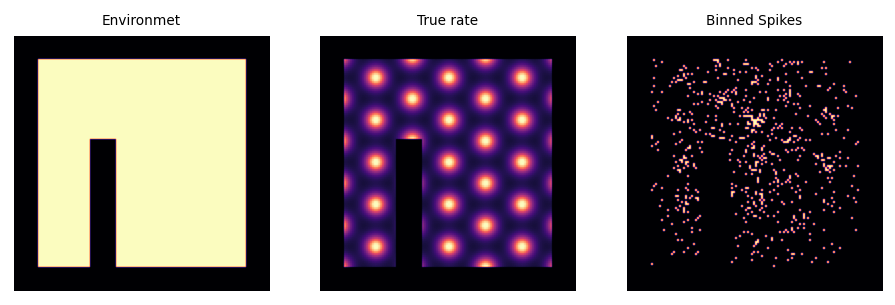

In [17]:
L = 128  # Grid size
P = L/7 # Grid spacing
α = 0.5  # Grid "sharpness"
μ = 1500/L**2 # Mean firing rate (spikes per sample)
mask,λ0,λ0_bg,N,K = simulate_data(L,P,α,μ)
subplot(131); showim(mask,'Environmet')
subplot(132); showim(λ0,'True rate')
subplot(133); showim(K,'Binned Spikes');

fgσ  = P/pi
bgσ  = fgσ*5

# Bessel function
coords = zgrid(L)
kernR  = j0(fftshift(abs(coords*2*pi/P)))
window = hanning(L)
window = outer(window,window)
kernR  = kernR*fftshift(window)
fftkr  = fftshift(real(ifft2(kernR)))

# Restrict kernel to local neighborhood and normalize
k3     = jn_zeros(0,3)[-1]
fwin   = abs(coords)<P*k3/(2*pi)
kern0  = kernR*fftshift(fwin)
kern0  = blur(kern0,P/pi)
kern0  = kern0/np.max(kern0)

# Prepare data
lλb  = slog(kdeλ(N,K,bgσ))     # Log background (initial estimate)
lλf  = slog(kdeλ(N,K,fgσ))-lλb # Log foreground (initial estimate)
n    = N.ravel()               # Number of visits per bin
y    = nan_to_num(K/N).ravel() # Lumped pseudo-observerations
lλb  = lλb.ravel()             # Background offsets

# Fast Hartley transform 

In [18]:
# Precompute variables; Passed as globals to jac/hess
kern    = kern0*zerolag(radial_acorr(lλf,mask))
kern    = repair_small_eigenvalues(kern,1e-5)
Kf      = np0.array(real(fft2(kern)))
Kf[0,0]+= 1e1
Λf      = 1.0/Kf
K0      = ifft2(Kf)
Kh      = real(Kf)+imag(Kf)
Λh      = real(Λf)+imag(Λf)
Σ0      = cop(Kf)
Λ0      = cop(Λf)

lndΣ0 = sum(log(Kf))

In [19]:
#  Pick which components to keep 
thr    = np.max(array(sorted(abs(Kf).ravel()))[:-1])/2
keep2d = abs(Kf)>thr
keep   = where(keep2d.ravel())[0]
R      = len(keep)
print('Keeping R=%d out of %d components'%(R,L*L))
print('Check approximation accuracy',max(abs(fht2(Kh*keep2d)-K0)))

# Jax can't do assignment so we build these projection matrices
down = eye(L*L)[keep]
up   = down.T
Λh   = down@(real(Λf) + imag(Λf)).ravel()

def reverse(A):
    A = roll(A[::-1,:],1,axis=0)
    A = roll(A[:,::-1],1,axis=1)
    return A

permutation = int32(down@reverse((up@(arange(R))).reshape(L,L)).ravel())

@jit
def hconv(kh,xh):
    kr = kh[permutation]
    xr = xh[permutation]
    a  = kh+kr
    b  = kh-kr
    return (xh*a+xr*b)/2

@jit
def hconm(kh,Q):
    return array([hconv(kh,q) for q in Q.T]).T

@jit
def collapse(v):
    return fht2(v.reshape(L,L)).ravel()[keep]

@jit
def expand(x):
    v = zeros((L*L,)).at[keep].set(x).reshape(L,L)
    v = fft2(v,norm='ortho').ravel()
    return real(v) + imag(v)

@jit
def expandAleft(A):
    A = zeros((L*L,R)).at[keep].set(A).reshape(L,L,R)
    A = fft2(A,axes=(0,1),norm='ortho').reshape(L*L,R)
    A = real(A) + imag(A)
    return A

@jit
def collapseAleft(x):
    x = x.reshape(L,L,R)
    x = fft2(x,axes=(0,1),norm='ortho')
    x = real(x) + imag(x)
    x = x.reshape(L*L,R)
    x = x[keep,:]
    return x


Keeping R=133 out of 16384 components
Check approximation accuracy 68.3151602876176


In [20]:
μ0 = lλb.ravel()
u = randn(L*L)
μ = lλf.ravel()
Q = tril(randn(R,R) + eye(R))*1e-1
Q = chol(Q@Q.T + eye(R)*1e-3)
M = tril(randn(R,R) + eye(R))*1e-1
M = chol(M@M.T + eye(R)*1e-3)

@jit
def loss(μ,Q):
    Q = tril(Q)
    FQ = expandAleft(Q)
    Σ  = FQ@FQ.T
    λ  = exp(μ+μ0+diag(Σ)/2)
    ε  = λ-y*μ
    trΛ0Σ = sum(FQ*conm(Λf,FQ))
    μΛ0μ  = μ.T @ conv(Λf,μ)
    lndΣ  = logdet(Q@Q.T)
    return  n@ε + μΛ0μ/2 + lndΣ0/2 - lndΣ/2 + trΛ0Σ/2

@jit
def Jμ(μ,Q):
    Q = tril(Q)
    FQ = expandAleft(Q)
    v  = sum(FQ**2,1)
    λ  = exp(μ+μ0+v/2)
    return n*(λ-y) + conv(Λf,μ)
print('∇μ')
Jμ_jax = jit(grad(loss,0))
j0 = Jμ_jax(μ,Q)
j1 = Jμ(μ,Q)
print('jax vs. analytic error: %0.8f'%mean(abs(j1-j0)))

@jit
def Hvμ(μ,Q,u):
    Q = tril(Q)
    FQ = expandAleft(Q)
    nλ = n*exp(μ+μ0+sum(FQ**2,1)/2)
    return nλ*u + conv(Λf,u)
print('∇<∇μ,u>')
tic()
Hvμ_jax = jit(lambda u: grad(lambda μ: vdot(grad(loss,0)(μ,Q), u))(μ))
x0 = Hvμ_jax(u)
x1 = Hvμ(μ,Q,u)
print('jax vs. analytic error: %0.8f'%mean(abs(x1-x0)))

@jit
def JQ(μ,Q):
    Q = tril(Q)
    FQ = expandAleft(Q)
    nλ = n*exp(μ+μ0+sum(FQ**2,1)/2)
    P  = inv(Q)
    FdλFtQ = collapseAleft(nλ[:,None]*FQ)
    FΛ0FtQ = hconm(Λh,Q)
    result = FΛ0FtQ + FdλFtQ - P.T
    return tril(result)
print('∇Q')
JQ_jax = jit(grad(loss,1))
j0 = JQ_jax(μ,Q)
j1 = JQ(μ,Q)
print('jax vs. analytic error: %0.8f'%mean(abs(j1-j0)))

@jit
def HvQ(μ,Q,M):
    Q = tril(Q)
    M = tril(M)
    FM  = expandAleft(M)
    FQ  = expandAleft(Q)
    d   = n*exp(μ+μ0+sum(FQ**2,1)/2)
    r   = d * sum(FQ*FM,1)
    dFM = d[:,None]*FM
    rFQ = r[:,None]*FQ
    dFMrFQ = dFM + rFQ
    ΛM     = hconm(Λh,M)
    PtMtPt = tdivu(Q.T,tdivl(Q,M).T)
    return tril(collapseAleft(dFMrFQ) + ΛM + PtMtPt)
print('∇<∇Q,M>')
HvQ_jax = jit(lambda M:grad(lambda Q:vdot(grad(loss,1)(μ,Q),M))(Q))
j0 = HvQ_jax(M)
j1 = HvQ(μ,Q,M)
print('jax vs. analytic error: %0.8f'%mean(abs(j1-j0)))

∇μ
jax vs. analytic error: 0.00000000
∇<∇μ,u>
jax vs. analytic error: 0.00000000
∇Q
jax vs. analytic error: 0.00000000
∇<∇Q,M>
jax vs. analytic error: 0.00000000


In [21]:
def showfig():
    figure(figsize=(6,2))
    subplot(121)
    imshow(μ.reshape(L,L))
    axis('off')
    colorbar()
    subplot(122)
    FQ = expandAleft(Q.reshape(R,R))
    imshow(sum(FQ**2,1).reshape(L,L))
    axis('off')
    colorbar()
    show()
    
Kh  = down@(real(Kf) + imag(Kf)).ravel()
tol       = 1e-5
minrestol = 1e-4
Rlt = (R*(R+1))//2
hconv = jit(hconv)
hconm = jit(hconm)
conv  = jit(conv)
Jμ0   = jit(lambda μ  :n*(exp(μ+μ0)-y) + conv(Λf,μ))
Hvμ0  = jit(lambda μ,u:n* exp(μ+μ0)*u  + conv(Λf,u))
pμ    = op(L*L,lambda u:conv(Kf,u).ravel())
pQ    = op(Rlt,lambda M:tril_elements(hconm(Kh,tril_elements(M,R))))

@jit
def HvQ0_helper(M,nλ,FQ,Pt):
    FM  = expandAleft(M)
    r   = nλ * sum(FQ*FM,1)
    dFM = nλ[:,None]*FM
    rFQ = r[:,None]*FQ
    ΛM  = hconm(Λh,M)
    PMP = Pt@M.T@Pt
    return collapseAleft(dFM+rFQ) + ΛM + PMP

@jit
def prepareJQ(μ,Q):
    Q  = tril(Q)
    FQ = expandAleft(Q)
    nλ = n*exp(μ+μ0+sum(FQ**2,1)/2)
    Pt = inv(Q).T
    FdλFtQ = collapseAleft(nλ[:,None]*FQ)
    FΛ0FtQ = hconm(Λh,Q)
    J  = tril_elements(FΛ0FtQ + FdλFtQ - Pt)
    return nλ,FQ,Pt,J

nλ,FQ,Pt,J = prepareJQ(μ,Q)
HvQ0_helper(M,nλ,FQ,Pt);

μ 0 21.458133465697173
μ 1 1.1442511939178486
μ 2 1.152525868842449
μ 3 1.1696239576962664
μ 4 1.1422614786659506
μ 5 1.1061594124515368
μ 6 2.18856302139473
μ 7 1.2091909891551487
μ 8 1.154366013246122
μ 9 1.1167024300438844
μ 10 0.923628953734226
μ 11 0.5188105740375915
μ 12 0.12125191416629086
μ 13 0.0052515059046956605
μ 14 1.1810478439467847e-05
μ 15 1.0454265493440392e-07
μ 15 6.145706327533854e-10
Q 15 1.479151353716372
μ 15 4.5367706913891295e-11
Q 15 0.12012004321734795
μ 15 2.325043681570552e-12
Q 15 0.0017777317821899966
μ 15 1.274336351783302e-13
Q 15 2.4716821540759448e-05
μ 15 7.192108844620711e-15
Q 15 3.1002533783786377e-07
converged
Δt = 14251 ms elapsed for time2


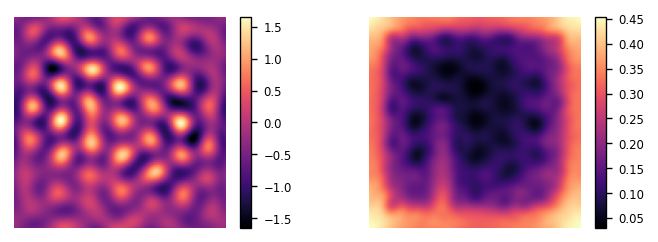

In [22]:
tic()
μ = lλf.ravel()
for i in range(100):
    J  = Jμ0(μ)
    Hv = op(L*L,lambda u:Hvμ0(μ,u).ravel())
    Δ  = minres(Hv,J.ravel(),M=pμ,tol=minrestol)[0]
    μ -= Δ
    ε = max(abs(Δ))
    print('μ',i,ε)
    if ε<tol: break
Kh = down@(real(Kf) + imag(Kf)).ravel()
nλ = n*exp(μ+μ0)
Hv = op(R, jit(lambda u: collapse(nλ*expand(u))))
pc = op(R, lambda u: hconv(Kh,u))
Σ  = array([minres(Hv,v,tol=1e-2)[0] for v in eye(R)])
Σ  = (Σ+Σ.T)/2
Q  = chol(Σ + eye(R)*1e-4)
for j in range(100):
    FQ = expandAleft(tril(Q))
    vc = sum(FQ**2,1)/2
    m  = vc + μ0
    nλ = n*exp(μ+m)
    J  = nλ - n*y + conv(Λf,μ)
    Hv = op(L*L,lambda u:(nλ*u + conv(Λf,u)).ravel())
    Δ  = minres(Hv,Jμ0(μ).ravel(),M=pμ,tol=minrestol)[0]
    μ -= Δ
    εμ = max(abs(Δ))
    print('μ',i,εμ)
    J  = tril_elements(JQ(μ,Q))
    Q  = tril(Q)
    FQ = expandAleft(Q)
    nλ = n*exp(μ+μ0+sum(FQ**2,1)/2)
    Pt = ltinv(Q).T
    HvQ0 = lambda M:HvQ0_helper(M,nλ,FQ,Pt)
    Hv = op(Rlt,lambda M:tril_elements(HvQ0(tril_elements(M,R))))
    Δ  = minres(Hv,J,M=pQ,tol=minrestol)[0]
    Δ  = tril_elements(Δ,R)
    Q -= Δ
    εQ = max(abs(Δ))
    print('Q',i,εQ)
    if εμ<tol and εQ<tol: 
        print('converged')
        break
tic('time2')
showfig()